ta


# Modelització

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn import preprocessing

In [128]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, f1_score, explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [129]:
st_songs = pd.read_csv('standarized_songs.csv', index_col=0)

In [130]:
st_songs

,album,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,popularity,...,Live From Clear Channel Stripped 2008,Speak Now,Fearless,1989,Taylor Swift,1989 (Taylor's Version),Red,evermore,Speak Now World Tour Live,reputation Stadium Tour Surprise Song Playlist
name,,,,,,,,,,,,,,,,,,,,,
Welcome To New York (Taylor's Version),1989 (Taylor's Version),0.000000,-2.781806,0.785933,0.591346,-1.373603,0.790658,0.347256,0.715106,0.66,...,False,False,False,False,False,True,False,False,False,False
Blank Space (Taylor's Version),1989 (Taylor's Version),0.782999,-1.828920,0.749235,0.739183,-3.189397,0.752375,0.198550,0.732774,0.67,...,False,False,False,False,False,True,False,False,False,False
Style (Taylor's Version),1989 (Taylor's Version),1.335679,-3.476973,0.409786,0.846154,-5.395998,0.794586,0.190107,0.295495,0.68,...,False,False,False,False,False,True,False,False,False,False
Out Of The Woods (Taylor's Version),1989 (Taylor's Version),1.777413,-3.439534,0.461774,0.921875,-1.287582,0.710092,0.169889,0.186175,0.67,...,False,False,False,False,False,True,False,False,False,False
All You Had To Do Was Stay (Taylor's Version),1989 (Taylor's Version),2.151533,-3.407025,0.527523,0.724760,-3.969891,0.737876,0.205225,0.532906,0.65,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Our Song,Taylor Swift,3.729809,-1.700224,0.649847,0.665865,-1.579464,0.784158,0.148515,0.553887,0.72,...,False,False,False,False,True,False,False,False,False,False
I'm Only Me When I'm With You,Taylor Swift,3.931746,-2.996480,0.489297,0.980769,-4.843296,0.877152,0.538748,0.530698,0.58,...,False,False,False,False,True,False,False,False,False,False
Invisible,Taylor Swift,4.122937,-0.426995,0.564220,0.331731,-3.593873,0.727591,0.198152,0.215989,0.55,...,False,False,False,False,True,False,False,False,False,False


*** QUEDA FER ESCALAT CORRECTE AMB EL X_TRAIN I Y_TRAIN ***

### Training i test split

In [157]:
X = st_songs.drop(columns = {'popularity', 'album'}).iloc[:,2:]
y = st_songs['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Lineal

In [132]:
# We instantiate a linear regression. 
lr = LinearRegression()

# Now we train it on train data with fit method
lr.fit(X_train,y_train)

# We can predict using the predict method
y_pred = lr.predict(X_train)

weights = lr.coef_
intercept = lr.intercept_
# You can access to some info about the model, like the weights.
print('Coeficients')
for x, y in zip(X.columns, weights[:]):
    print(x, y)
print('Intercept: \n', intercept)

print(len(weights))

Coeficients
danceability -0.00949075365277562
energy 0.0023315061960548153
liveness -0.004198467564297563
loudness 0.11686365320131112
tempo -0.032609976655149926
valence 0.0205933824140354
duration 0.05357809684215524
taylors_version 0.064975427552781
performed_live -0.18526602143443988
not_first_release -0.07525781049139216
low_instrumentalness -0.004203771438103224
medium_instrumentalness 0.00529754206601955
spoken_section -0.005192190377596522
Midnights 0.14609970603040912
Lover 0.16818889653066826
reputation 0.17105501555753122
Red (Taylor's Version) 0.0020077652368034197
folklore 0.08471619174554165
Speak Now (Taylor's Version) 0.014321209912249777
Fearless (Taylor's Version) -0.018783001023194898
Live From Clear Channel Stripped 2008 -0.08585625442980115
Speak Now -0.11774799736090444
Fearless -0.1590258331601942
1989 -0.05497476009795167
Taylor Swift -0.06016982807683864
1989 (Taylor's Version) 0.06742945342692021
Red -0.16854763854521704
evermore 0.1106968412586171
Speak Now W

In [133]:
### Molt important veure quins són els pesos dels coeficients 'album', ja que quan predim no en posarem ###

album_weights = weights[13:]

for x, y in zip(X.columns[13:], album_weights):
    print(x, y)
print('Intercept: \n', intercept)


Midnights 0.14609970603040912
Lover 0.16818889653066826
reputation 0.17105501555753122
Red (Taylor's Version) 0.0020077652368034197
folklore 0.08471619174554165
Speak Now (Taylor's Version) 0.014321209912249777
Fearless (Taylor's Version) -0.018783001023194898
Live From Clear Channel Stripped 2008 -0.08585625442980115
Speak Now -0.11774799736090444
Fearless -0.1590258331601942
1989 -0.05497476009795167
Taylor Swift -0.06016982807683864
1989 (Taylor's Version) 0.06742945342692021
Red -0.16854763854521704
evermore 0.1106968412586171
Speak Now World Tour Live 0.02702641244762087
reputation Stadium Tour Surprise Song Playlist -0.12643617945226257
Intercept: 
 0.5314622681067239


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'Midnights'),
  Text(1, 0, 'Lover'),
  Text(2, 0, 'reputation'),
  Text(3, 0, "Red (Taylor's Version)"),
  Text(4, 0, 'folklore'),
  Text(5, 0, "Speak Now (Taylor's Version)"),
  Text(6, 0, "Fearless (Taylor's Version)"),
  Text(7, 0, 'Live From Clear Channel Stripped 2008'),
  Text(8, 0, 'Speak Now'),
  Text(9, 0, 'Fearless'),
  Text(10, 0, '1989'),
  Text(11, 0, 'Taylor Swift'),
  Text(12, 0, "1989 (Taylor's Version)"),
  Text(13, 0, 'Red'),
  Text(14, 0, 'evermore'),
  Text(15, 0, 'Speak Now World Tour Live'),
  Text(16, 0, 'reputation Stadium Tour Surprise Song Playlist')])

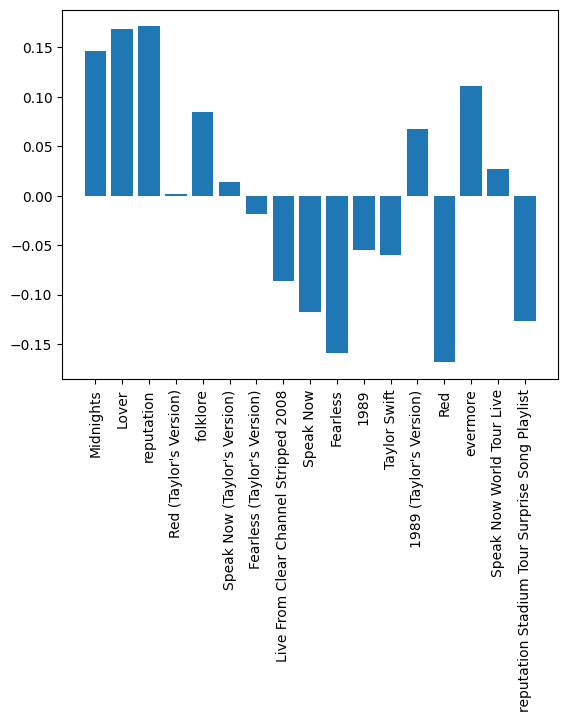

In [134]:
plt.bar(X.columns[13:], album_weights)
plt.xticks(rotation=90)

Veiem que els àlbums més recents (Midnights, evermore, folklore, Lover)...

name
Bad Blood                        0.014520
Long Live (Taylor's Version)     0.065362
ivy                             -0.041429
epiphany                        -0.003565
Bette Davis Eyes - Live/2011     0.021197
                                   ...   
Question...?                    -0.029712
Would've, Could've, Should've   -0.068513
invisible string                 0.066491
Enchanted - Live/2011           -0.015127
Bigger Than The Whole Sky       -0.015123
Name: popularity, Length: 395, dtype: float64


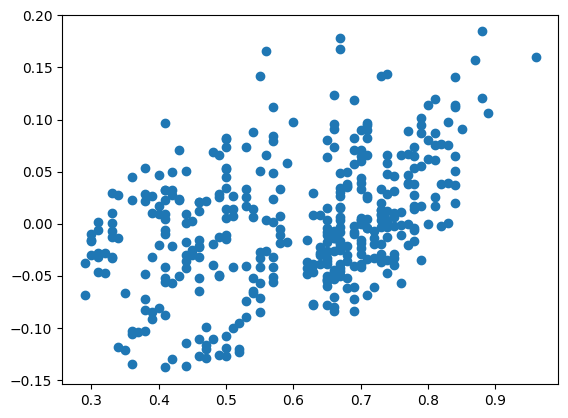

In [135]:
naive_prediction_error = y_train - y_pred
print(naive_prediction_error)

plt.scatter(y_train, naive_prediction_error)
plt.show()

In [136]:
mse = mean_squared_error(y_train, y_pred)
mse

0.0036894453368391034

In [137]:
R_squared = r2_score(y_train, y_pred)
norm_mse_sk = 1 - R_squared
norm_mse_sk, R_squared


(0.16311972957834886, 0.8368802704216511)

Cross validation

In [138]:
from sklearn.model_selection import LeaveOneOut

N = len(X_train)

lr_cv = LinearRegression()
lr_cv.fit(X_train, y_train)
folds_r2 = cross_val_score(lr_cv, X_train, y_train, cv = 10, scoring='r2')
lr_r2 = np.mean(folds_r2)
print(lr_r2)
print(folds_r2)

0.8132932551715392
[0.80445661 0.81881761 0.84447272 0.78629928 0.77848977 0.88008489
 0.81418269 0.74457727 0.86938039 0.79217132]


Veiem que el model lineal de moment explica molta variablitat.

#### Regularització

Ridge:

In [139]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [140]:
ridge_cv = RidgeCV(alphas=lambdas, cv = 10)
ridge_cv.fit(X_train, y_train)
print('Best Lambda:', ridge_cv.alpha_)
print('R2 SCORE: ', ridge_cv.best_score_)

Best Lambda: 0.3
R2 SCORE:  0.8137087422088717


In [141]:
abs(ridge_cv.coef_ - lr.coef_)

array([1.53335310e-03, 8.99234317e-03, 1.54002598e-04, 2.00444336e-02,
       5.09061837e-06, 3.83037151e-03, 1.15827493e-02, 1.27041936e-03,
       3.48411348e-03, 4.48031063e-04, 1.14046212e-03, 4.36948153e-03,
       1.31083615e-03, 5.21299633e-03, 4.49365458e-03, 5.57927630e-03,
       5.42299133e-04, 2.89482887e-03, 2.99282219e-03, 6.36898856e-04,
       6.75355031e-03, 5.39280598e-03, 4.17362812e-03, 8.91349896e-04,
       4.50957311e-03, 2.90160081e-03, 2.23087329e-03, 3.77200716e-03,
       3.79399271e-03, 5.24555882e-04])

No hi ha hagut massa diferència

#### Lasso

Ridge:

In [142]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [143]:
lasso_cv = LassoCV(alphas=lambdas, cv = 10)
lasso_cv.fit(X_train, y_train)
print('Best Lambda:', lasso_cv.alpha_)
lasso_r2 = r2_score(y_train, lasso_cv.predict(X_train))
print('R2 SCORE: ', lasso_r2)

Best Lambda: 0.0001
R2 SCORE:  0.8363074765086878


/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01927772559280716, tolerance: 0.0008015717183098591
  model = cd_fast.enet_coordinate_descent_gram(
/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021104462497221643, tolerance: 0.000792597915492958
  model = cd_fast.enet_coordinate_descent_gram(
/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020523334469753074, tolerance: 0.0008152198309859154
  model = cd_fast.

In [144]:
abs(lasso_cv.coef_ - lr.coef_)

array([0.00623752, 0.00664883, 0.00029607, 0.01939663, 0.00300141,
       0.00860375, 0.02164681, 0.0472814 , 0.02821434, 0.00109182,
       0.00420377, 0.00529754, 0.00519219, 0.03494951, 0.03762581,
       0.03647175, 0.00200777, 0.03866259, 0.00131011, 0.00086904,
       0.08585625, 0.04867854, 0.04618879, 0.0440783 , 0.04955384,
       0.00759541, 0.04496036, 0.03836905, 0.06925646, 0.07542682])

No hi ha hagut massa diferència

## Random forest i Decision tree

In [145]:
rf = RandomForestRegressor(oob_score=True)
model_rf = rf.fit(X_train, y_train)

y_pred_tree = model_rf.predict(X_train)

print(r2_score(y_train, y_pred_tree))
print(mean_squared_error(y_train, y_pred_tree))
print(1 - r2_score(y_train, y_pred_tree))


print('OOB accuracy=', model_rf.oob_score_)

0.9601744140160171
0.0009007759078273592
0.03982558598398289
OOB accuracy= 0.7945223350874794


MOLT baix error -> Però segurament és degut a overfitting (salt entre r2_score i OOB score)
La precisió pel OOB set és bastant bona, però.

Podriem afegir GridSearch (tant al DecisionTree com al RandomForest) !

### GridSearch per Decision Tree

Anem a veure si un Decision Tree SOL és capaç de fer una bona regressió.

10 folds CV

In [146]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

In [147]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [8, 9, 10, 11, 12],  # values around 10
    'min_samples_split': [2, 3, 4, 5, 6],  # values around 4
    'min_samples_leaf': [5, 6, 7, 8, 9],  # values around 7
    'max_features': ['sqrt', 'log2', None]  # including None as it was the best in the previous run
}

scoring = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_dt = DecisionTreeRegressor(random_state=42,**best_params)

# Fit the new decision tree to the training data
best_dt.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_decision_tree = best_dt.predict(X_test)

In [148]:
print(r2_score(y_test, y_pred_best_decision_tree))

0.7675902124721636


In [149]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_r2
285,11,2,7,None,-0.053631,-0.004864,0.781279
286,11,3,7,None,-0.053631,-0.004864,0.781279
289,11,6,7,None,-0.053631,-0.004864,0.781279
287,11,4,7,None,-0.053631,-0.004864,0.781279
288,11,5,7,None,-0.053631,-0.004864,0.781279


Un bon decision tree! Quasi el 80% de la variància explicada per ambdós nivell de folds. És bàsicament tant bo com el RF sense Grid Search.

Coses a veure: hi ha poc overfitting perquè el r2 mitjà de la CV és quasi igual al de r2 de generalització?

### GridSearch per Random Forest

In [154]:
param_grid = {
    'n_estimators': [200], # 200 is the best, tried for 10 and 100 too
    'max_depth': [8],  # values around 10. 8 was the best
    'min_samples_split': [2, 3, 4, 5, 6],  # values around 4
    'min_samples_leaf': [5],  # values around 7. 5 was best
    'max_features': ['sqrt', 'log2', None]  # including None as it was the best in the previous run
}

scoring = {
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Create a decision tree regressor
rf = RandomForestRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)  

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new decision tree with the best parameters
best_rf = RandomForestRegressor(oob_score=True,random_state=42,**best_params)

# Fit the new decision tree to the training data
best_rf.fit(X_train, y_train)

# Predict using the new decision tree
y_pred_best_rf = best_rf.predict(X_test)

In [155]:
print('OOB accuracy=', best_rf.oob_score_)

OOB accuracy= 0.804533239678519


0.778857230559681


<Axes: xlabel='popularity'>

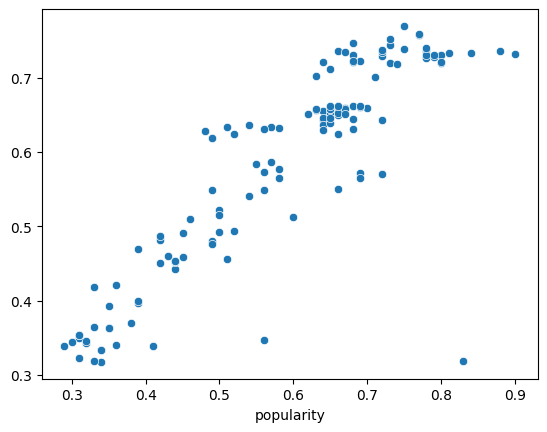

In [156]:
print(r2_score(y_test, y_pred_best_rf))

sns.scatterplot(x=y_test, y=y_pred_best_rf)

In [157]:
best_rf.n_estimators

200

In [158]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
    'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error', 'mean_test_r2'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_r2
10,8,2,5,None,-0.053233,-0.004631,0.792813
11,8,3,5,None,-0.053233,-0.004631,0.792813
12,8,4,5,None,-0.053233,-0.004631,0.792813
13,8,5,5,None,-0.053233,-0.004631,0.792813
14,8,6,5,None,-0.053233,-0.004631,0.792813


## SVM

In [159]:
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor

In [160]:
def compute_metrics(y_pred, y_real):
    r2 = r2_score(y_pred,y_real)
    median_abs_e = median_absolute_error(y_pred, y_real)
    mse = mean_squared_error(y_pred, y_real)
    mean_abs_e = mean_absolute_error(y_pred, y_real)
    return [r2, mse, median_abs_e, mean_abs_e]

In [161]:
results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Baseline el KNN

    Kernel  C epsilon        R2       MSE median_absolute_error  \
KNN      -  -       -  0.729857  0.005887                 0.032   

    mean_absolute_error  
KNN            0.048848  


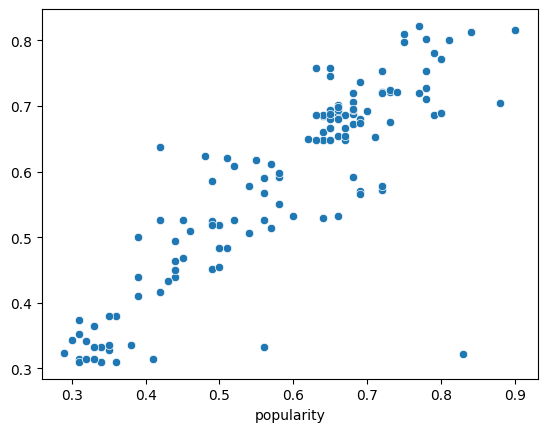

In [162]:
knn = KNeighborsRegressor()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


sns.scatterplot(x=y_test, y=y_pred)

results.loc['KNN', :] = ['-', '-','-'] + compute_metrics(y_pred,y_test)
print(results)

/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
KNN,-,-,-,0.729857,0.005887,0.032,0.048848
LinearSVR-default,linear,1,0,0.720579,0.005936,0.03563,0.050124


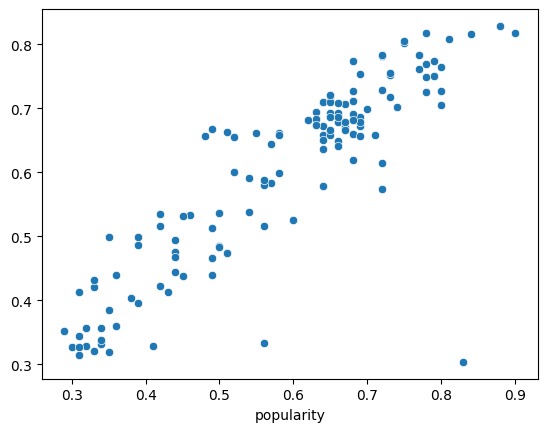

In [163]:
svm = LinearSVR()

svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

results.loc['LinearSVR-default', :] = ['linear',1,0] + compute_metrics(y_pred,y_test)

sns.scatterplot(x=y_test, y=y_pred)

results.sort_values(by='R2', ascending=False)

SVM with parameters "gridsearch"?

In [176]:
cv_results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Cs = [1, 1.5, 2, 2.5, 3, 5] # values less than 10
epsilons = [0.0001, 0.00001, 0.000001, 0.0000001,0]
for c in Cs:
    for epsilon in epsilons:
        svm = SVR(kernel='linear', C=c,epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = svm.predict(X_test)
        cv_results.loc['LinearSVR-{}-{}'.format(c,epsilon), :] = ['linear', c, epsilon] + compute_metrics(y_pred,y_test)
        
best = cv_results.sort_values(by='R2',ascending=False).iloc[0,:]
results.loc['LinearSVR-best',:] = best

In [177]:
cv_results.sort_values(by='R2', ascending=False)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-3-0,linear,3,0,0.738915,0.005351,0.032457,0.045964
LinearSVR-2-0,linear,2,0,0.738811,0.005348,0.032429,0.045939
LinearSVR-5-0,linear,5,0,0.738712,0.005348,0.032353,0.045959
LinearSVR-1-1e-07,linear,1,0.0,0.738309,0.005351,0.032092,0.045875
LinearSVR-2.5-1e-07,linear,2.5,0.0,0.738216,0.005357,0.032229,0.045917
LinearSVR-10-0,linear,10,0,0.738141,0.005351,0.031682,0.045864
LinearSVR-2.5-1e-06,linear,2.5,0.000001,0.73812,0.005353,0.031657,0.045876
LinearSVR-3-1e-06,linear,3,0.000001,0.738102,0.005354,0.031767,0.045883
LinearSVR-5-1e-07,linear,5,0.0,0.738068,0.005353,0.032035,0.04589
LinearSVR-3-1e-07,linear,3,0.0,0.738067,0.005356,0.031763,0.045888


In [178]:
results.sort_values(by='R2', ascending=False)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
rbfSVR-best,rbf,2,0.00001,0.754999,0.005084,0.024258,0.042567
LinearSVR-best,linear,3,0,0.738915,0.005351,0.032457,0.045964
KNN,-,-,-,0.729857,0.005887,0.032,0.048848
LinearSVR-default,linear,1,0,0.720579,0.005936,0.03563,0.050124
polySVR-best,poly,50,0.001,0.671217,0.007383,0.03403,0.056425
RBF-SVR-default,RBF,1,0,0.583031,0.006231,0.047385,0.058155
rbf-SVR-default,rbf,1,0,0.583031,0.006231,0.047385,0.058155
poly-SVR-default,poly,1,0,0.455901,0.009243,0.063212,0.074462
sigmoidSVR-best,sigmoid,2,0.0,-0.153639,78.762266,3.796118,5.722851
sigmoid-SVR-default,sigmoid,1,0,-0.159837,19.803588,1.962415,2.868427


## Non-linear SVR

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
rbfSVR-best,rbf,2,0.00001,0.754999,0.005084,0.024258,0.042567
LinearSVR-best,linear,3,0,0.738915,0.005351,0.032457,0.045964
KNN,-,-,-,0.729857,0.005887,0.032,0.048848
LinearSVR-default,linear,1,0,0.720579,0.005936,0.03563,0.050124
polySVR-best,poly,50,0.001,0.671217,0.007383,0.03403,0.056425
RBF-SVR-default,RBF,1,0,0.583031,0.006231,0.047385,0.058155
rbf-SVR-default,rbf,1,0,0.583031,0.006231,0.047385,0.058155
poly-SVR-default,poly,1,0,0.455901,0.009243,0.063212,0.074462
sigmoidSVR-best,sigmoid,2,0.0,-0.153639,78.762266,3.796118,5.722851
sigmoid-SVR-default,sigmoid,1,0,-0.159837,19.803588,1.962415,2.868427


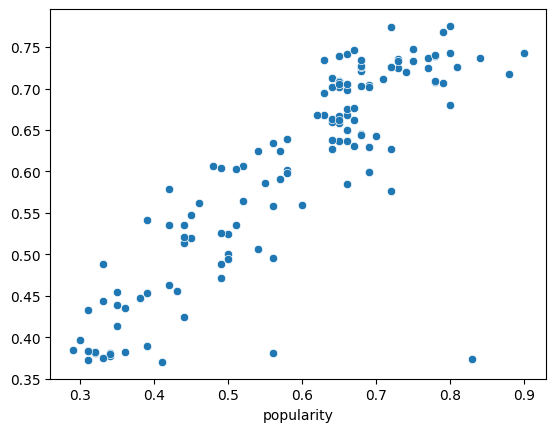

In [179]:
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)

results.loc['RBF-SVR-default', :] = ['RBF',1,0]+ compute_metrics(y_pred,y_test)

sns.scatterplot(x=y_test, y=y_pred)
results.sort_values(by='R2', ascending=False)

In [168]:

Cs = [1, 2, 2.5, 3, 5, 10, 15, 20, 30, 50]
epsilons = [0.001,0.0001,0.00001,0.000001, 0.0000001,0]
for kernel_type in ['rbf', 'sigmoid', 'poly']:
    
    svr = SVR(kernel=kernel_type)
    svr.fit(X_train,y_train)
    y_pred = svr.predict(X_test)

    results.loc[kernel_type+'-SVR-default', :] = [kernel_type,1,0]+ compute_metrics(y_pred,y_test)
    
    
    cv_results_rbf = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])
    for c in Cs:
        for epsilon in epsilons:
            svm = SVR(kernel=kernel_type, C=c,epsilon=epsilon)
            svm.fit(X_train,y_train)
            y_pred = svm.predict(X_test)
            cv_results_rbf.loc[kernel_type+'SVR-{}-{}'.format(c,epsilon), :] = [kernel_type, c, epsilon] + compute_metrics(y_pred,y_test)
            
    best = cv_results_rbf.sort_values(by='R2',ascending=False).iloc[0,:]
    results.loc[kernel_type+'SVR-best',:] = best


results.sort_values(by='R2', ascending=False)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
rbfSVR-best,rbf,2,0.00001,0.754999,0.005084,0.024258,0.042567
LinearSVR-best,linear,2,0,0.738811,0.005348,0.032429,0.045939
KNN,-,-,-,0.729857,0.005887,0.032,0.048848
LinearSVR-default,linear,1,0,0.720579,0.005936,0.03563,0.050124
polySVR-best,poly,50,0.001,0.671217,0.007383,0.03403,0.056425
RBF-SVR-default,RBF,1,0,0.583031,0.006231,0.047385,0.058155
rbf-SVR-default,rbf,1,0,0.583031,0.006231,0.047385,0.058155
poly-SVR-default,poly,1,0,0.455901,0.009243,0.063212,0.074462
sigmoidSVR-best,sigmoid,2,0.0,-0.153639,78.762266,3.796118,5.722851
sigmoid-SVR-default,sigmoid,1,0,-0.159837,19.803588,1.962415,2.868427


In [169]:
results.sort_values(by='R2', ascending=False)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
rbfSVR-best,rbf,2,0.00001,0.754999,0.005084,0.024258,0.042567
LinearSVR-best,linear,2,0,0.738811,0.005348,0.032429,0.045939
KNN,-,-,-,0.729857,0.005887,0.032,0.048848
LinearSVR-default,linear,1,0,0.720579,0.005936,0.03563,0.050124
polySVR-best,poly,50,0.001,0.671217,0.007383,0.03403,0.056425
RBF-SVR-default,RBF,1,0,0.583031,0.006231,0.047385,0.058155
rbf-SVR-default,rbf,1,0,0.583031,0.006231,0.047385,0.058155
poly-SVR-default,poly,1,0,0.455901,0.009243,0.063212,0.074462
sigmoidSVR-best,sigmoid,2,0.0,-0.153639,78.762266,3.796118,5.722851
sigmoid-SVR-default,sigmoid,1,0,-0.159837,19.803588,1.962415,2.868427


In [170]:
kernel_type='poly'
svr = SVR(kernel=kernel_type)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)

results.loc[kernel_type+'-SVR-default', :] = [kernel_type,1,0]+ compute_metrics(y_pred,y_test)

Cs = [10, 15, 20, 25, 30, 50]
epsilons = [0.001,0.0001,0.00001,0.000001, 0.0000001,0]

cv_results_rbf = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])
for c in Cs:
    for epsilon in epsilons:
        svm = SVR(kernel=kernel_type, C=c,epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = svm.predict(X_test)
        cv_results_rbf.loc[kernel_type+'SVR-{}-{}'.format(c,epsilon), :] = [kernel_type, c, epsilon] + compute_metrics(y_pred,y_test)
        
best = cv_results_rbf.sort_values(by='R2',ascending=False).iloc[0,:]
results.loc[kernel_type+'SVR-best',:] = best

In [171]:
results.sort_values(by='R2', ascending=False)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
rbfSVR-best,rbf,2,0.00001,0.754999,0.005084,0.024258,0.042567
LinearSVR-best,linear,2,0,0.738811,0.005348,0.032429,0.045939
KNN,-,-,-,0.729857,0.005887,0.032,0.048848
LinearSVR-default,linear,1,0,0.720579,0.005936,0.03563,0.050124
polySVR-best,poly,50,0.001,0.671217,0.007383,0.03403,0.056425
RBF-SVR-default,RBF,1,0,0.583031,0.006231,0.047385,0.058155
rbf-SVR-default,rbf,1,0,0.583031,0.006231,0.047385,0.058155
poly-SVR-default,poly,1,0,0.455901,0.009243,0.063212,0.074462
sigmoidSVR-best,sigmoid,2,0.0,-0.153639,78.762266,3.796118,5.722851
sigmoid-SVR-default,sigmoid,1,0,-0.159837,19.803588,1.962415,2.868427


## Outlier Removal

<Axes: xlabel='popularity'>

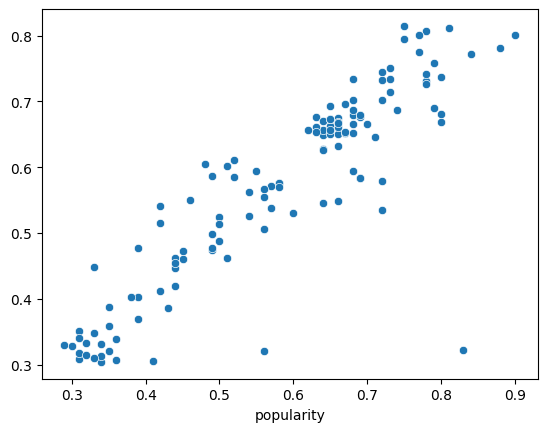

In [180]:
best_svm = SVR(kernel='rbf', C=2.5, epsilon=0.0)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

sns.scatterplot(x=y_test, y=y_pred)

In [181]:
sorted_differences = np.abs(y_test-y_pred).sort_values(ascending=False)
sorted_differences

name
I Don’t Wanna Live Forever (Fifty Shades Darker)    0.507602
So It Goes...                                       0.239142
Our Song                                            0.185210
Style                                               0.140863
champagne problems                                  0.132042
                                                      ...   
Style (Taylor's Version)                            0.001344
Welcome To New York (Taylor's Version)              0.001223
Midnight Rain                                       0.001167
Bejeweled                                           0.000849
This Love                                           0.000783
Name: popularity, Length: 132, dtype: float64

In [199]:
sorted_differences.index[0]

'I Don’t Wanna Live Forever (Fifty Shades Darker)'

In [207]:
st_songs.loc[sorted_differences.index[0],:]

album                                             reputation Stadium Tour Surprise Song Playlist
track_number                                                                            3.515456
acousticness                                                                           -2.045598
danceability                                                                            0.746177
energy                                                                                  0.393029
liveness                                                                               -3.749917
loudness                                                                                0.535105
tempo                                                                                   0.354159
valence                                                                                 0.075751
popularity                                                                                  0.83
duration                      

## Using boosting

We combine boosting with gridsearch to obtain the best estimators possible

In [139]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {  # ja he provat amb molts més valors, aquests son els que millor ho fan
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_depth': [2, 3, 4, 5],
    'loss': ['squared_error']
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=10, refit='r2', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"The r2 score on test set: {r2:.4f}")

The r2 score on test set: 0.7773


In [141]:
scoring_cols = ['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_loss', 'mean_train_score', 'mean_test_score']
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)[scoring_cols].head()

,param_n_estimators,param_learning_rate,param_max_depth,param_loss,mean_train_score,mean_test_score
20,200,0.05,4,squared_error,0.956885,0.807691
19,150,0.05,4,squared_error,0.943097,0.807468
4,150,0.1,3,squared_error,0.948376,0.805923
2,200,0.1,2,squared_error,0.912597,0.805770
18,100,0.05,4,squared_error,0.916647,0.805197


We see that there is a bunch of overfitting.

In [244]:
importances = grid_search.best_estimator_.feature_importances_

# Print feature importances
for feature_name, importance in zip(X_train.columns, importances):
    print(f"{feature_name}: {importance:.4f}")

danceability: 0.0119
energy: 0.0198
liveness: 0.0217
loudness: 0.0352
tempo: 0.0122
valence: 0.0137
duration: 0.0259
taylors_version: 0.0364
performed_live: 0.3042
not_first_release: 0.0718
low_instrumentalness: 0.0000
medium_instrumentalness: 0.0000
spoken_section: 0.0000
Midnights: 0.0248
Lover: 0.0293
reputation: 0.0213
Red (Taylor's Version): 0.0000
folklore: 0.0139
Speak Now (Taylor's Version): 0.0006
Fearless (Taylor's Version): 0.0024
Live From Clear Channel Stripped 2008: 0.0000
Speak Now: 0.0625
Fearless: 0.1012
1989: 0.0194
Taylor Swift: 0.0037
1989 (Taylor's Version): 0.0050
Red: 0.1420
evermore: 0.0109
Speak Now World Tour Live: 0.0070
reputation Stadium Tour Surprise Song Playlist: 0.0031


we can see that performed live is very important, and that not_first_release is also pretty important. Some albums are much more important than others.

In [217]:
_, X_test, _, _ = train_test_split(st_songs, y, test_size=0.25, random_state=42)
X_test
X_test['y_pred'] = y_pred

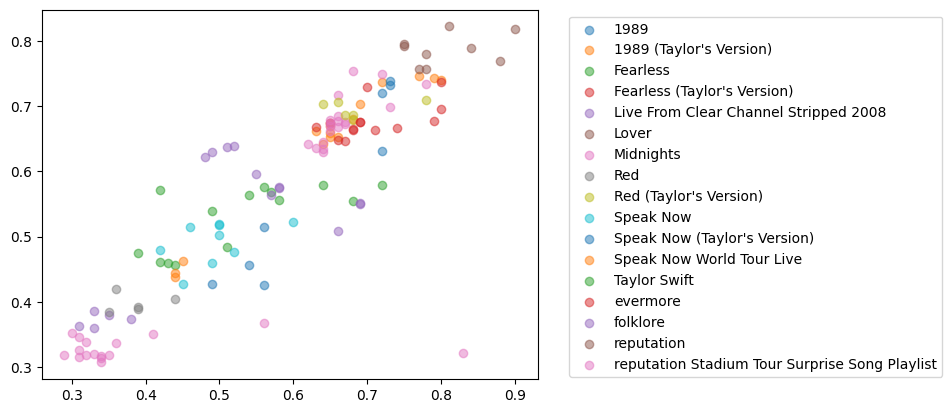

In [222]:
X_test['album_code'] = X_test['album'].astype('category').cat.codes
album_names = X_test['album'].astype('category').cat.categories

for album in album_names:
    subset = X_test[X_test['album'] == album]
    plt.scatter(subset['popularity'], subset['y_pred'], label=album, alpha=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

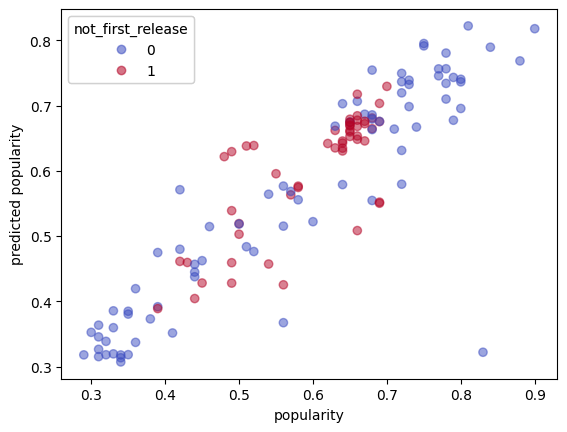

In [232]:
scatter = plt.scatter(X_test['popularity'], X_test['y_pred'], alpha=0.5, c=X_test['not_first_release'], cmap='coolwarm')
plt.xlabel('popularity')
plt.ylabel('predicted popularity')

legend1 = plt.legend(*scatter.legend_elements(), title="not_first_release")
plt.gca().add_artist(legend1)

plt.show()